In [12]:
from utilities import *

DATA PRE-PROCESSING

In [13]:
Data = pd.read_csv('Churn.csv')
df =Data.copy()

In [14]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [15]:
# dropping columns rownumber, customerid and surname as they will not add value to the models:
df.drop(['CustomerId','Surname'], axis=1, inplace=True)

Binning the Age column to create a categorical variable. 

In [16]:
# Binning the age column
df['Age'].unique()

# Define bins and labels for the age groups
bins = [18, 30, 40, 50, 60, 93]
labels = ['18-29', '30-39', '40-49', '50-59', '60+']

# Bin the ages
age_groups = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Display the binned ages
age_groups
#adding this to the df
df = df.assign(Age_binned=age_groups)


Binning the creditscore column to create a categorical variable

In [17]:
# binning the creditscore column
# Define bins for credit score ranges
credit_bins = [349, 450, 550, 650, 750, 850]
credit_labels = ['350-449', '450-549', '550-649', '650-749', '750-850']

# Bin the credit scores
credit_score_groups = pd.cut(df['CreditScore'], bins=credit_bins, labels=credit_labels, right=True)

# Display the binned credit scores
credit_score_groups
#adding this to the df
df = df.assign(CreditScore_binned=credit_score_groups)

In [18]:
# dropping the columns RowNumber, Age and CreditScore
data = df.drop(['RowNumber','Age','CreditScore'], axis=1)

In [19]:
# Loop through the columns and convert only object columns to categorical
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Geography           10000 non-null  category
 1   Gender              10000 non-null  category
 2   Tenure              10000 non-null  int64   
 3   Balance             10000 non-null  float64 
 4   NumOfProducts       10000 non-null  int64   
 5   HasCrCard           10000 non-null  int64   
 6   IsActiveMember      10000 non-null  int64   
 7   EstimatedSalary     10000 non-null  float64 
 8   Exited              10000 non-null  int64   
 9   Age_binned          10000 non-null  category
 10  CreditScore_binned  10000 non-null  category
dtypes: category(4), float64(2), int64(5)
memory usage: 586.7 KB


TRAIN -VALIDATION-TEST-SPLIT

In [20]:
# sepearting independent from dependent variables
X = data.drop(['Exited'],axis=1)
Y = data['Exited']

# Splitting the dataset into the Training and Test set.
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42,stratify = Y)


# Splitting the Train dataset into the Training and Validation set.
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size = 0.2, random_state = 42,stratify = y_train)


#Printing the shapes.
print(X_train.shape,y_train.shape)
print(X_valid.shape,y_valid.shape)
print(X_test.shape,y_test.shape)

(6400, 10) (6400,)
(1600, 10) (1600,)
(2000, 10) (2000,)


Dummy variable creation of categorical cariables

In [21]:
# creating dummy variables
X_train = pd.get_dummies(X_train,drop_first = True)
X_valid = pd.get_dummies(X_valid,drop_first = True)
X_test = pd.get_dummies(X_test,drop_first = True)

print(X_train.shape, X_valid.shape, X_test.shape)
X_train.head()
X_train.columns

(6400, 17) (1600, 17) (2000, 17)


Index(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Geography_Germany', 'Geography_Spain',
       'Gender_Male', 'Age_binned_30-39', 'Age_binned_40-49',
       'Age_binned_50-59', 'Age_binned_60+', 'CreditScore_binned_450-549',
       'CreditScore_binned_550-649', 'CreditScore_binned_650-749',
       'CreditScore_binned_750-850'],
      dtype='object')

Data normalization 

In [22]:
#Standardizing the numerical variables to zero mean and unit variance.
transformer = StandardScaler()
X_train[['Tenure','Balance','NumOfProducts','EstimatedSalary']] = transformer.fit_transform(X_train[['Tenure','Balance','NumOfProducts','EstimatedSalary']])
X_valid[['Tenure','Balance','NumOfProducts','EstimatedSalary']] = transformer.fit_transform(X_valid[['Tenure','Balance','NumOfProducts','EstimatedSalary']])
X_test[['Tenure','Balance','NumOfProducts','EstimatedSalary']] = transformer.fit_transform(X_test[['Tenure','Balance','NumOfProducts','EstimatedSalary']])

Building base model

The model can make wrong predictions as:
predicting the customer did not leave the bank and the customer actually leaving the bank.
Predicting the customer leaving the bank and the customer actually not leaving the bank.
Predicting the customer not leaving the bank and the customer actually leaving the bank is a more important case.
The company would want recall to be minimized, as the greater the recall the higher the chances of minimizing false negatives.
Hence the metric of importance is RECALL.

Neural Network with SGD Optimizer

In [23]:
# defining the batch size and # epochs upfront as I'll be using the same values for all models
epochs = 25
batch_size = 64

This neural network consists of:
2 hidden layers with 14 and 7 neurons respectively
Relu activation for both hidden layers
SGD as optimizer
sigmoid activation for output layer because it is a binary classification problem.

In [35]:
#Initializing the neural network
model = Sequential()
model.add(Dense(14,activation="relu",input_dim=X_train.shape[1]))
model.add(Dense(7,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 14)                252       
                                                                 
 dense_7 (Dense)             (None, 7)                 105       
                                                                 
 dense_8 (Dense)             (None, 1)                 8         
                                                                 


Total params: 365 (1.43 KB)
Trainable params: 365 (1.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/25
100/100 [==============================] - 0s 1ms/step - loss: 0.5985 - val_loss: 0.5372
Epoch 2/25
100/100 [==============================] - 0s 684us/step - loss: 0.5139 - val_loss: 0.5132
Epoch 3/25
100/100 [==============================] - 0s 670us/step - loss: 0.4993 - val_loss: 0.5050
Epoch 4/25
100/100 [==============================] - 0s 669us/step - loss: 0.4917 - val_loss: 0.4989
Epoch 5/25
100/100 [==============================] - 0s 659us/step - loss: 0.4855 - val_loss: 0.4937
Epoch 6/25
100/100 [==============================] - 0s 665us/step - loss: 0.4798 - val_loss: 0.4888
Epoch 7/25
100/100 [==============================] - 0s 660us/step - loss: 0.4746 - val_loss: 0.4843
Epoch 8/25
100/100 [==============================] - 0s 645us/step - loss: 0.4696 - val_loss: 0.4800
Epoch 9/25
100/100 [==============================] - 0s 663us/step - loss: 0.4648 - val_loss: 0.4758
Epoch 10/25
100/100 [==============================] - 0s 656us/step - loss: 0.4602 

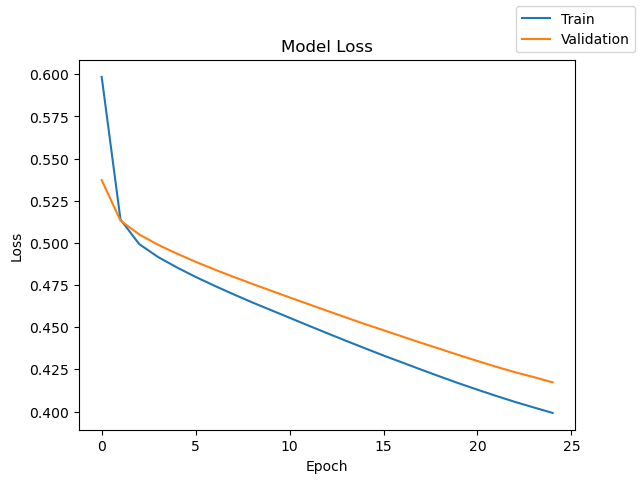

In [36]:
optimizer = tf.keras.optimizers.SGD()    # defining SGD as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs)
end=time.time()

print("Time taken in seconds ",end-start)

plot(history,'loss')



In [37]:
# Performance check
model1_train_performance = model_performance_classification(model,X_train,y_train)
print(model1_train_performance)

model1_valid_performance = model_performance_classification(model,X_valid,y_valid)
print(model1_valid_performance)



200/200 [==============================] - 0s 554us/step
   Accuracy    Recall  Precision  F1 Score
0  0.823594  0.823594   0.804929   0.78767
50/50 [==============================] - 0s 396us/step
   Accuracy   Recall  Precision  F1 Score
0   0.81875  0.81875   0.796022  0.781494


The difference between train recall and validation score is less than ~1% which is a consistent performance of the model between the training and validation dataset.
A score of above 80% for both training and validation dataset is good but has the potential to perform better with some other model improvements.

Model Improvements:

Keeping the SGD optimizer and adding momentum to check whether it is accelerating the process.

Neural Network with SGD Optimizer + momentum

In [38]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [39]:
#Initializing the neural network
model = Sequential()
model.add(Dense(14,activation="relu",input_dim=X_train.shape[1]))
model.add(Dense(7,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                252       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 365 (1.43 KB)
Trainable params: 365 (1.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/25
100/100 [==============================] - 0s 2ms/step - loss: 0.5385 - val_loss: 0.4953
Epoch 2/25
100/100 [==============================] - 0s 678us/step - loss: 0.4708 - val_loss: 0.4626
Epoch 3/25
100/100 [==============================] - 0s 733us/step - loss: 0.4323 - val_loss: 0.4361
Epoch 4/25
100/100 [==============================] - 0s 674us/step - loss: 0.4057 - val_loss: 0.4163
Epoch 5/25
100/100 [==============================] - 0s 664us/step - loss: 0.3878 - val_loss: 0.4028
Epoch 6/25
100/100 [==============================] - 0s 678us/step - loss: 0.3752 - val_loss: 0.3897
Epoch 7/25
100/100 [==============================] - 0s 692us/step - loss: 0.3658 - val_loss: 0.3902
Epoch 8/25
100/100 [==============================] - 0s 659us/step - loss: 0.3607 - val_loss: 0.3781
Epoch 9/25
100/100 [==============================] - 0s 673us/step - loss: 0.3549 - val_loss: 0.3834
Epoch 10/25
100/100 [==============================] - 0s 671us/step - loss: 0.3539 

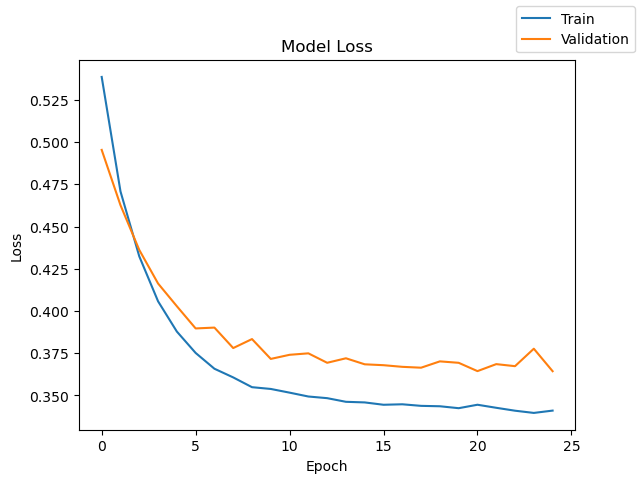

In [40]:
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)    # defining SGD as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs)
end=time.time()

print("Time taken in seconds ",end-start)

plot(history,'loss')


In [41]:
# Performance check
model2_train_performance = model_performance_classification(model,X_train,y_train)
print(model1_train_performance)

model2_valid_performance = model_performance_classification(model,X_valid,y_valid)
print(model2_valid_performance)



200/200 [==============================] - 0s 389us/step
   Accuracy    Recall  Precision  F1 Score
0  0.823594  0.823594   0.804929   0.78767
50/50 [==============================] - 0s 379us/step
   Accuracy    Recall  Precision  F1 Score
0  0.846875  0.846875   0.833956  0.833197



The recall on the validation dataset (~84.6%) is better than that of the training datase(~82.3%), which is good as it dincates it has the potential to perfrom well on unseen data. 
A score of above 80% for both training and validation dataset is good but has the potential to perform better with some other model improvements.

Neural Network with SGD Optimizer